# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [80]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

Let's start off by having a look at each of the 3 dataframes before we proceed with analysis to get a better understanding of how to process the data 

In [2]:
print(portfolio.head())
print(portfolio.info())
print(portfolio.describe())

                       channels  difficulty  duration  \
0       [email, mobile, social]          10         7   
1  [web, email, mobile, social]          10         5   
2          [web, email, mobile]           0         4   
3          [web, email, mobile]           5         7   
4                  [web, email]          20        10   

                                 id     offer_type  reward  
0  ae264e3637204a6fb9bb56bc8210ddfd           bogo      10  
1  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo      10  
2  3f207df678b143eea3cee63160fa8bed  informational       0  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo       5  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7       discount       5  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null i

In [3]:
print(profile.head())
print(profile.info())
print(profile.describe())

   age  became_member_on gender                                id    income
0  118          20170212   None  68be06ca386d4c31939f3a4f0e3dd783       NaN
1   55          20170715      F  0610b486422d4921ae7d2bf64640c50b  112000.0
2  118          20180712   None  38fe809add3b4fcf9315a9694bb96ff5       NaN
3   75          20170509      F  78afa995795e4d85b5d9ceeca43f5fef  100000.0
4  118          20170804   None  a03223e636434f42ac4c3df47e8bac43       NaN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB
None
                age  became_member_on         income
count  17000.000000      1.700000e+04   14825.000000
mean      62.531412      2.016703e+07   65404.991568

In [4]:
print(transcript.head())
print(transcript.info())
print(transcript.describe())

            event                            person  time  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1  offer received  a03223e636434f42ac4c3df47e8bac43     0   
2  offer received  e2127556f4f64592b11af22de27a7932     0   
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586     0   
4  offer received  68617ca6246f4fbc85e91a2a49552598     0   

                                              value  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB
None
             

From the above three dataframes it seems that the profile dataframe has the information about the customers and their demographics. The portfolio dataframe tells us more about each offer's characteristics. Also observe that the  finally transcript dataframe tells more about the person and whether they purchased a product or used the offer. 

The next step in the process is to have a look at the incomplete or missing values. 

In [5]:
print(transcript.isnull().sum())
print(portfolio.isnull().sum())
print(profile.isnull().sum())

event     0
person    0
time      0
value     0
dtype: int64
channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64
age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64


So from the above query it seems that the gender and income column in the profile portfolio has null values. Before we can address the null values, lets have a better understanding of what these null values.

In [6]:
profile_null= profile[(profile['age'].isnull()==True)& (profile['gender'].isnull()==True)]
print(profile_null.head())
print(profile_null.info())
print(profile_null.describe())
print('The percent of data missing is {}'.format(len(profile_null)/len(profile)*100))

Empty DataFrame
Columns: [age, became_member_on, gender, id, income]
Index: []
<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 5 columns):
age                 0 non-null int64
became_member_on    0 non-null int64
gender              0 non-null object
id                  0 non-null object
income              0 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 0.0+ bytes
None
       age  became_member_on  income
count  0.0               0.0     0.0
mean   NaN               NaN     NaN
std    NaN               NaN     NaN
min    NaN               NaN     NaN
25%    NaN               NaN     NaN
50%    NaN               NaN     NaN
75%    NaN               NaN     NaN
max    NaN               NaN     NaN
The percent of data missing is 0.0


The % of missing data is around 13%, making it difficult to delete it since doing so will reduce the sample size and might lead to sample bias. To get a better understanding of how to address the missing data, lets have a look at these two columns. 

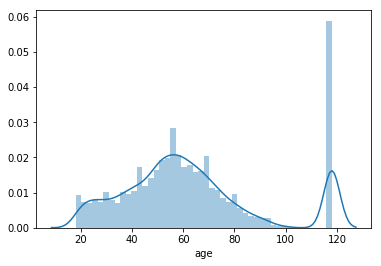

In [7]:
sns.distplot(profile['age'])

Notice that there is a large spike in age after 100 years old. This might suggest that the user filled in the data entry carelessly. At the same time, we are better off deleting the data since it will not be useful for targeting demographics. 

In [8]:
profile['age'] = profile['age'][profile['age']  <= 100]
profile = profile.dropna()
profile['age'].head()

1     55.0
3     75.0
5     68.0
8     65.0
12    58.0
Name: age, dtype: float64

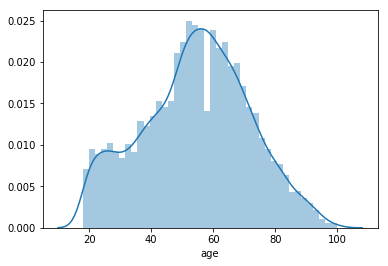

In [9]:
sns.distplot(profile['age'])

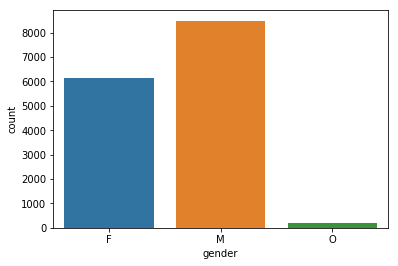

In [10]:
sns.countplot(profile['gender'])

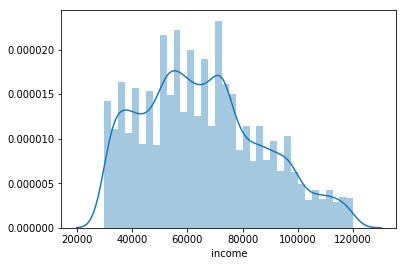

In [11]:
sns.distplot(profile['income'])

In [12]:
profile['income'].describe()

count     14820.000000
mean      65404.183536
std       21598.763284
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

From the plots above, it seems that most of the customers are middle-aged, slightly leaning towards male and have an average income of $65k.

Next, we are going to reconcile all dataframes into one main dataframe and then split it into two seperate dataframe based on whether the customer used an offer id or conducted a purchase. 

In [13]:
profile = profile.dropna()
portfolio = portfolio.rename(columns = {'id':'offer_id'})

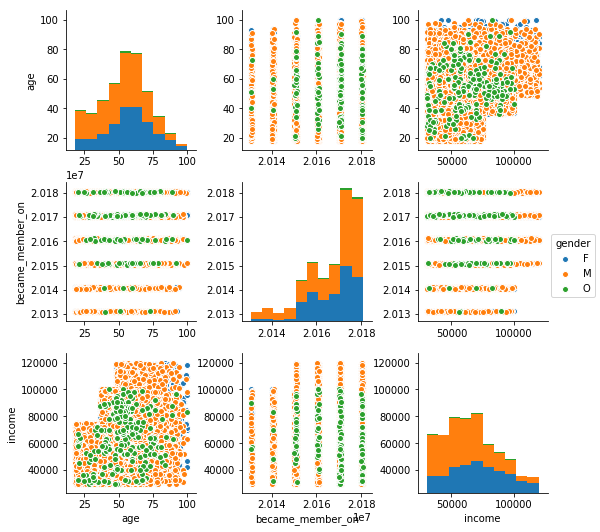

In [14]:
sns.pairplot(profile, hue = "gender")

In [15]:
profile = profile.rename(columns = {'id':'customer_id'})
profile.head()

,age,became_member_on,gender,customer_id,income
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68.0,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65.0,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58.0,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [16]:
transcript = transcript.rename(columns = {'person':'customer_id'})
transcript.head()

,event,customer_id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [17]:
df = pd.merge(profile,transcript, on = 'customer_id')
df.head()

,age,became_member_on,gender,customer_id,income,event,time,value
0,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,18,{'amount': 21.51}
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,144,{'amount': 32.28}
2,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer received,408,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
3,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer received,504,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
4,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,528,{'amount': 23.22}


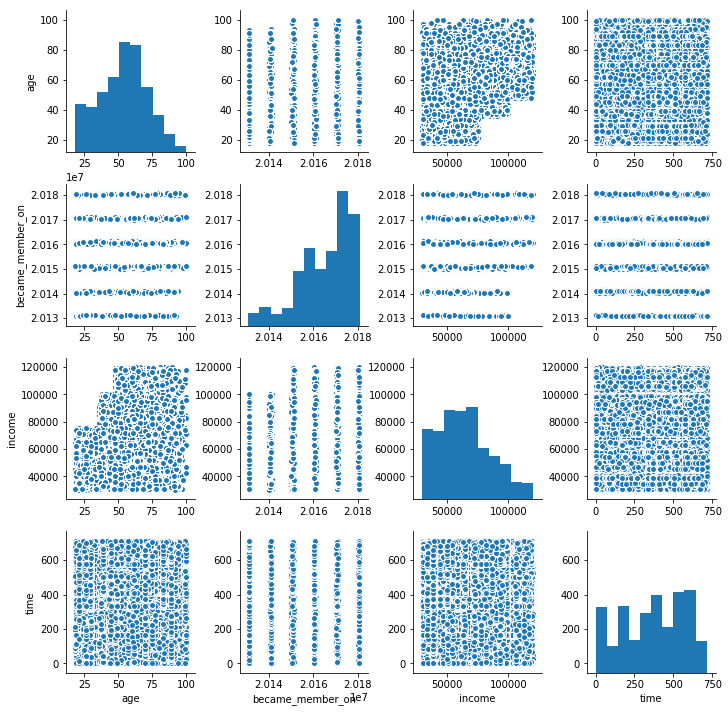

In [18]:
sns.pairplot(df)

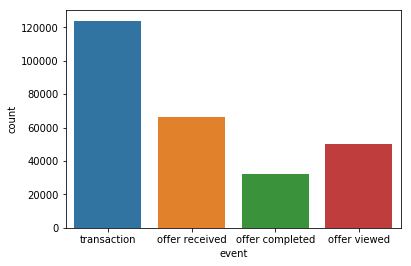

In [19]:
sns.countplot(df['event'])

It seems that most of the purchases that were made by the customers were transactions. 

In [20]:
value = pd.DataFrame.from_records(df['value'])
value.head()

,amount,offer id,offer_id,reward
0,21.51,NaN,NaN,NaN
1,32.28,NaN,NaN,NaN
2,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
3,NaN,3f207df678b143eea3cee63160fa8bed,NaN,NaN
4,23.22,NaN,NaN,NaN


In [21]:
#joining the two offer_id columns into one
value.columns = value.columns.str.replace('offer id', 'offer_id')
s = value.stack()
value = s.unstack()

In [22]:
#adding an additional coversion column
value['conversion'] = value['reward']
value['conversion'] = value['conversion'].fillna(0)
value['amount'] = value['amount'].fillna(0)

In [23]:
#joining the two dataframes
df = df.join(value)

Here we are going to split the data into two- those who purchased the product and those who didn't/used their offer/didnt utilize the offer

In [24]:
df_offer = df[df['offer_id'].notna() == True]
df_purchase = df[df['offer_id'].notna() == False]

In [25]:
df_purchase = df_purchase.drop(columns = {'value','offer_id','reward','conversion'})

In [26]:
df1 = pd.merge(df_offer, portfolio, on = ['offer_id'], how = 'outer') # pd.merge(df1, df2, on='Customer_id', how='inner')

In [27]:
df1

,age,became_member_on,gender,customer_id,income,event,time,value,amount,offer_id,reward_x,conversion,channels,difficulty,duration,offer_type,reward_y
0,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer received,408,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0.0,"[web, email, mobile]",5,7,bogo,5
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer completed,528,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5.0,"[web, email, mobile]",5,7,bogo,5
2,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,offer received,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0.0,"[web, email, mobile]",5,7,bogo,5
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,offer viewed,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0.0,"[web, email, mobile]",5,7,bogo,5
4,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,offer completed,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5.0,"[web, email, mobile]",5,7,bogo,5
5,68.0,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,offer received,408,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0.0,"[web, email, mobile]",5,7,bogo,5
6,68.0,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,offer viewed,420,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0.0,"[web, email, mobile]",5,7,bogo,5
7,68.0,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,offer completed,522,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5.0,"[web, email, mobile]",5,7,bogo,5
8,65.0,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,offer received,168,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0.0,"[web, email, mobile]",5,7,bogo,5
9,65.0,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,offer viewed,192,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0.0,"[web, email, mobile]",5,7,bogo,5


In [28]:
df1 = df1.drop(columns = 'reward_y')
df1 = df1.rename(columns = {'reward_x':'reward'})
df1 = df1.drop(columns = 'value')

In [29]:
df1['reward'] = df1['reward'].fillna(0)
df1['conversion'] = df1['reward']/df1['conversion']
df1['conversion'] = df1['conversion'].fillna(0)

the conversion rate for the offers is 0.21802438926012074


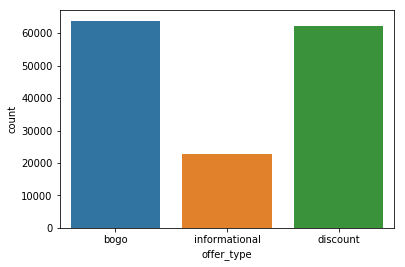

In [30]:
sns.countplot(df1['offer_type'])
print('the conversion rate for the offers is {}'.format(df1['conversion'].mean()))

The above query is surprising, despite the fact that most of the offers provide the customer with a discount or a free coffee, many of them still chose not to go through with the offer. 

count    148754.000000
mean      66413.346868
std       21497.147774
min       30000.000000
25%       51000.000000
50%       65000.000000
75%       81000.000000
max      120000.000000
Name: income, dtype: float64


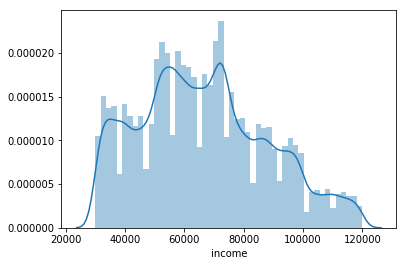

In [31]:
sns.distplot(df1['income'])
print(df1['income'].describe())

count    148754.000000
mean         54.763435
std          17.175163
min          18.000000
25%          43.000000
50%          56.000000
75%          67.000000
max         100.000000
Name: age, dtype: float64


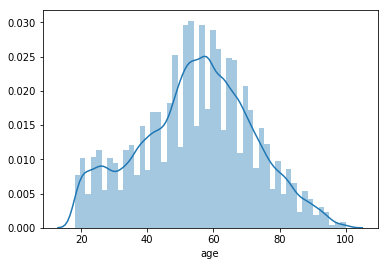

In [32]:
sns.distplot(df1['age'])
print(df1['age'].describe())

The above graph shines a better light as to why people choose not to redeem the offer even though they have a higher expected payoff. The mean age of the customer that was presented with an offer was 54 with the 25%-75% between 43 and 67. This explains why most of them didnt choose to use their offer. Firstly, the offers that were presented to them were in some electronic form - text, email rather than the traditional physical vouchers that this age group has used for the most part of their life. 


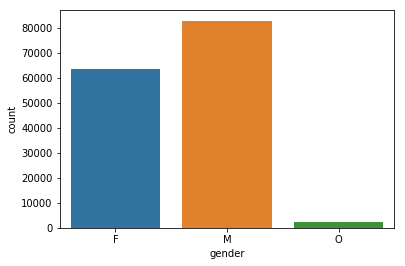

In [33]:
sns.countplot(df1['gender'])

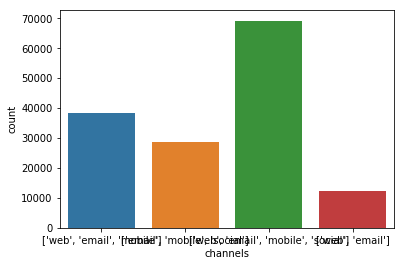

In [34]:
sns.countplot(df1['channels'].astype(str))

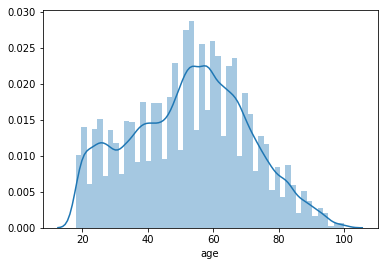

In [35]:
sns.distplot(df_purchase['age'])

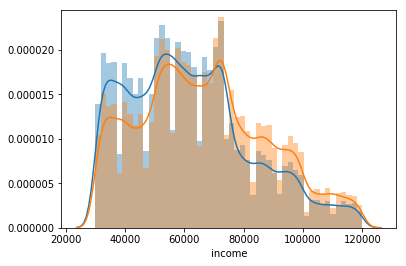

In [36]:
sns.distplot(df_purchase['income'])
sns.distplot(df_offer['income'])

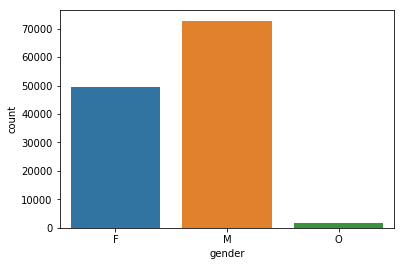

In [37]:
sns.countplot(df_purchase['gender'])

In [38]:
df1['channels'] = df1['channels'].astype(str)

In [39]:
df1['channels'] = df1['channels'].str.strip('[]')

In [40]:
channels = df1['channels'].str.split(',', expand = True)

In [42]:
df1['channels'] = df1['channels'].str.split(',', expand = True)

In [49]:
df1 = df1.join(channels)

In [45]:
df1 = df1.rename(columns ={'channels':'web'})

In [46]:
channels = channels.rename(columns = {0:'web',1:'email',2:'mobile',3:'social'})

In [54]:
df1 = df1.join(channels, lsuffix = 'web')

In [57]:
df1 = df1.drop(columns = 'webweb')

In [70]:
print(df1.groupby(['offer_type']).size())

offer_type
bogo             63828
discount         62278
informational    22648
dtype: int64


In [104]:
df1['social'] = df1['social'].fillna(0)

In [105]:
df1['web'] = df1['web']

,age,became_member_on,gender,customer_id,income,event,time,amount,offer_id,reward,conversion,difficulty,duration,offer_type,web,email,mobile,social
0,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer received,408,0.0,4,0.0,0.0,5,7,bogo,'web','email','mobile',0
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer completed,528,0.0,4,5.0,1.0,5,7,bogo,'web','email','mobile',0
2,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,offer received,0,0.0,4,0.0,0.0,5,7,bogo,'web','email','mobile',0
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,offer viewed,6,0.0,4,0.0,0.0,5,7,bogo,'web','email','mobile',0
4,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,offer completed,132,0.0,4,5.0,1.0,5,7,bogo,'web','email','mobile',0
5,68.0,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,offer received,408,0.0,4,0.0,0.0,5,7,bogo,'web','email','mobile',0
6,68.0,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,offer viewed,420,0.0,4,0.0,0.0,5,7,bogo,'web','email','mobile',0
7,68.0,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,offer completed,522,0.0,4,5.0,1.0,5,7,bogo,'web','email','mobile',0
8,65.0,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,offer received,168,0.0,4,0.0,0.0,5,7,bogo,'web','email','mobile',0
9,65.0,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,offer viewed,192,0.0,4,0.0,0.0,5,7,bogo,'web','email','mobile',0


In [60]:
df1['offer_id'] = df1['offer_id'].map({'ae264e3637204a6fb9bb56bc8210ddfd': 1, 
                                     '4d5c57ea9a6940dd891ad53e9dbe8da0': 2,
                                     '3f207df678b143eea3cee63160fa8bed': 3,
                                     '9b98b8c7a33c4b65b9aebfe6a799e6d9': 4,
                                     '0b1e1539f2cc45b7b9fa7c272da2e1d7': 5,
                                     '2298d6c36e964ae4a3e7e9706d1fb8c2': 6,
                                     'fafdcd668e3743c1bb461111dcafc2a4': 7,
                                     '5a8bc65990b245e5a138643cd4eb9837': 8,
                                     'f19421c1d4aa40978ebb69ca19b0e20d': 9, 
                                     '2906b810c7d4411798c6938adc9daaa5': 10,})

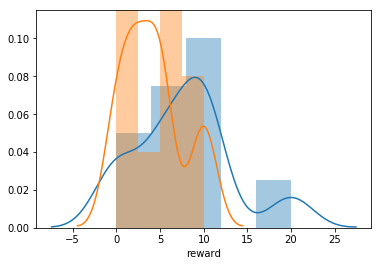

In [39]:
sns.distplot(portfolio['difficulty'])
sns.distplot(portfolio['reward'])
plt.legend(labels=['difficulty','reward'])

In [79]:
export = df1.to_csv('data/starbucks.csv')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


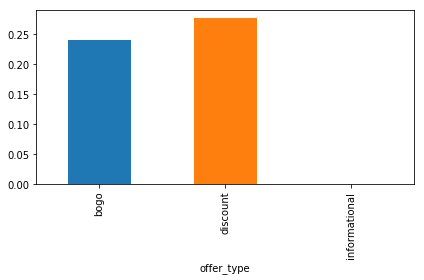

In [81]:
rcParams.update({'figure.autolayout': True})
  
df1.groupby(['offer_type'])['conversion'].mean().plot.bar()
plt.show()

Here it looks like that informational offers have almost no conversions, which is expected. However, it is surprising to see that the discount offers have more conversions than bogo offers. 

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


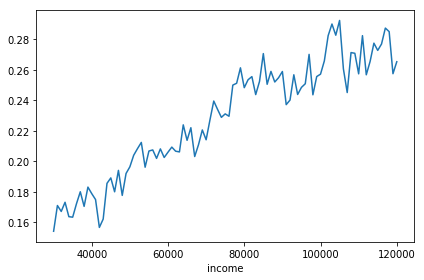

In [85]:
df1.groupby(['income'])['conversion'].mean().plot()
plt.show()

Interesting to observe that there was higher conversions observed for those who have a higher income

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


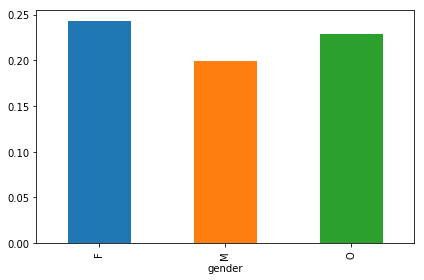

In [86]:
df1.groupby(['gender'])['conversion'].mean().plot.bar()
plt.show()

Surprisingly from above, despite O making a small proportion of the sample size, they had a higher conversion rate than M which has the largest proportion of the demographic. 

In [91]:
df1.groupby(['reward']).size()

reward
0.0     116322
2.0       8906
3.0       4885
5.0      11674
10.0      6967
dtype: int64

In [ ]:
Most of the rewards have no incentive for the customer to complete the offfer, which would explain why the offers have a low conversion rate despite having discounts and bogo reward. 

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


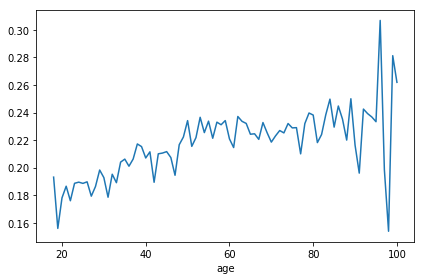

In [96]:
df1.groupby(['age'])['conversion'].mean().plot()

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


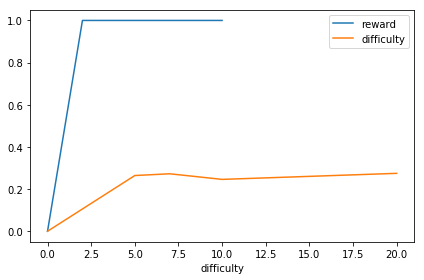

In [100]:
df1.groupby(['reward'])['conversion'].mean().plot()
df1.groupby(['difficulty'])['conversion'].mean().plot()
plt.legend(labels=['reward','difficulty'])

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


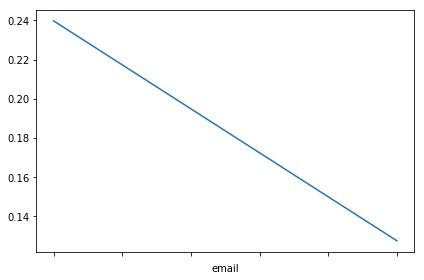

In [102]:
df1.groupby(['email'])['conversion'].mean().plot()